# Global Velocity dispersion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dynamicAll.base import Data
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpyro.distributions as dist

## Loading a data set

In [3]:
data_path = "/Users/juan/Desktop/dracoish.txt"

In [4]:
input_data = pd.read_csv(data_path, header=0).dropna()  # drop all nan values
input_data

,RA,DEC,MAG_G,MAG_I,ANGSEP,RPROJ,SNR,VTRUE,VSTAT,VSYS,VMEAS,VMEASERR,VSYSERR,VERR
0,53.88518,-54.02280,23.32272,23.12567,0.07122,0.09447,5.41586,44.11046,-0.68338,0.70942,44.13650,4.16485,2.0,4.62017
1,54.06523,-53.93597,17.65393,16.74092,0.07465,0.09902,363.11669,72.04525,0.03049,3.05323,75.12897,0.02679,2.0,2.00018
2,54.06599,-53.77255,19.90599,19.92407,0.23075,0.30608,68.42616,56.36690,-0.17761,-0.02299,56.16629,0.19849,2.0,2.00983
3,54.02349,-53.97031,23.25164,23.05304,0.03274,0.04343,5.71572,65.04756,2.09910,-5.76456,61.38210,3.90405,2.0,4.38652
4,54.02006,-53.96624,21.72529,21.27512,0.03576,0.04743,25.99445,59.43007,0.01197,-0.68023,58.76180,0.63408,2.0,2.09811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,53.87506,-53.98700,21.87238,21.42785,0.07459,0.09894,23.23569,48.53974,-0.14664,1.43758,49.83068,0.72546,2.0,2.12751
11048,54.02857,-54.20824,22.87137,22.61137,0.20891,0.27711,8.54196,69.48248,-2.54854,-3.29287,63.64107,2.41063,2.0,3.13228
11049,53.85962,-53.76057,22.81739,22.53252,0.25333,0.33603,9.07093,67.13552,-1.77017,-0.58418,64.78117,2.24294,2.0,3.00513
11050,54.15867,-53.91983,19.48593,18.89245,0.12306,0.16323,124.43928,64.93852,-0.18654,1.14014,65.89211,0.09684,2.0,2.00234


In [5]:
vlos = input_data["VMEAS"].values
dvlos = input_data["VERR"].values

### Global velocity dispersion

The first thing we might want to do with kinematic data from a dwarf galaxy is calculate the global dipersion. 

This is done by fitting the velocities with a Gaussian Distribution

$$
\mathcal{L}(\mu,\sigma |v_{\rm los}, \delta v_{los}) = \prod_i \frac{1}{\sqrt{2\pi(\sigma^{2}+\delta v_{\rm los,i}^{2})}} \exp\left(-\frac{(v_i - \mu)^2}{2(\sigma^{2} + \delta v_{los,i}^2)}\right)
$$

As default we use uniformative priors on $\mu$ and $\sigma$.

Prior on $\mu$ is a uniform distribution between -1000 and 1000 km/s.
prior on $\sigma$ is a uniform distribution between 0 and 1000 km/s

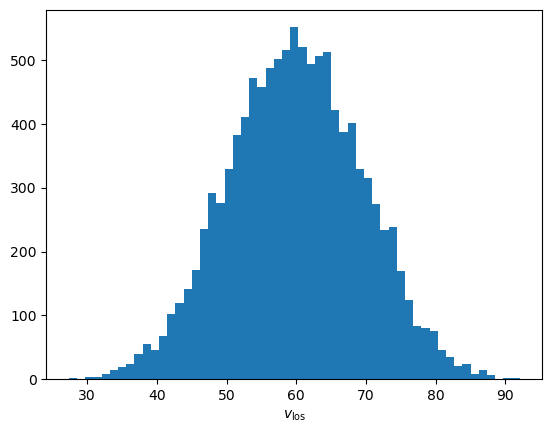

In [6]:
fig, ax = plt.subplots()
ax.hist(vlos, bins="auto")
ax.set(xlabel=r"$v_{\rm los}$");

The default priors are:
```python
priors = {"mu": dist.Uniform(-1000, 1000), "sigma": dist.Uniform(0, 1000)}
```
which you dont have to specify so you can just call the function with the data and the errors.

```python
mcmc = dataset.global_dispersion(dataset._vlos, dataset.d_vlos)
```

Looking at the histogram of velocities we can probably make that prior a bit better

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

         mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  ess_bulk  \
mu     59.908  0.091   59.809   59.988      0.001    0.001    6449.0   
sigma   8.912  0.068    8.844    8.980      0.001    0.001    3456.0   

       ess_tail  r_hat  
mu       4118.0    1.0  
sigma    3558.0    1.0  


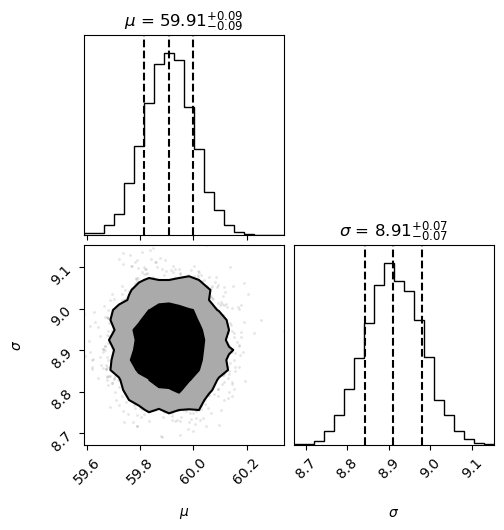

In [7]:
priors = {"mu": dist.Uniform(0, 100), "sigma": dist.Uniform(0, 100)}

mcmc = Data.global_dispersion(vlos, dvlos, plot=True, priors=priors)

global_disperison returns a numpyro MCMC object which you can use to get the samples and the log likelihoods

In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     59.91      0.09     59.91     59.76     60.06   6414.92      1.00
     sigma      8.91      0.07      8.91      8.79      9.02   3437.11      1.00

Number of divergences: 0


For more info/control of the posteriors, it's useful to use arviz.

Below we show how to use arviz to calculate the 68% and 95% credible intervals the mean velocity and the velocity dispersion.
We then use corner to plot the posteriors.

Index(['mean', 'sd', 'hdi_16%', 'hdi_84%', 'mcse_mean', 'mcse_sd', 'ess_bulk',
       'ess_tail', 'r_hat', 'median'],
      dtype='object')
         mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  ess_bulk  \
mu     59.908  0.091   59.809   59.988      0.001    0.001    6449.0   
sigma   8.912  0.068    8.844    8.980      0.001    0.001    3456.0   

       ess_tail  r_hat  median  
mu       4118.0    1.0  59.909  
sigma    3558.0    1.0   8.911  

mean mu: 59.908
median mu: 59.909
16th percentile: 59.809
84th percentile: 59.988
mean sigma: 8.912
median sigma: 8.911
16th percentile: 8.844
84th percentile: 8.98


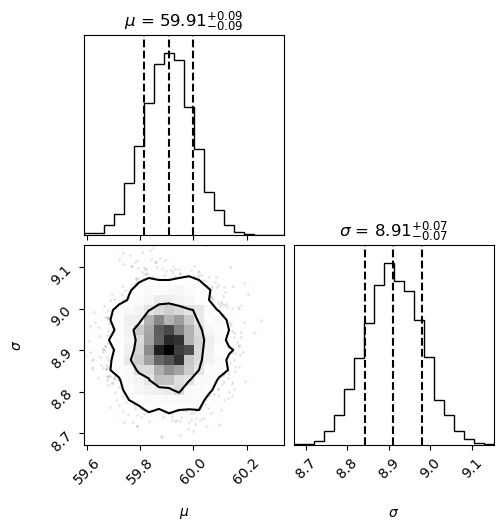

In [9]:
import corner
import arviz as az
import matplotlib.pyplot as plt

# mcmc.print_summary()
samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)
summary = az.summary(idata, hdi_prob=0.68, stat_funcs={"median": jnp.median})
print(summary.columns)
print(summary)
print()
print(f"mean mu: {summary['mean']['mu']}")
print(f"median mu: {summary['median']['mu']}")
print(f"16th percentile: {summary['hdi_16%']['mu']}")
print(f"84th percentile: {summary['hdi_84%']['mu']}")
print(f"mean sigma: {summary['mean']['sigma']}")
print(f"median sigma: {summary['median']['sigma']}")
print(f"16th percentile: {summary['hdi_16%']['sigma']}")
print(f"84th percentile: {summary['hdi_84%']['sigma']}")

_fig = corner.corner(
    samples,
    labels=[r"$\mu$", r"$\sigma$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    plot_datapoints=True,
    levels=(0.68, 0.95),
)
plt.show()

## Calculate mass enclosed within half light radius

If you know the half-light radius of the system, you could calcualate $M_{1/2}$ where
$$
M_{1/2}= \frac{3\langle\sigma_{los}^2\rangle r_{1/2}}{G} 
$$

usually only the projected half light radius is known

$$
M_{1/2} = \frac{4\langle\sigma_{los}^2\rangle R_{e}}{G}
$$
where $R_{e} = \frac{3}{4}r_{1/2}$ is the projected half light radius.
$$
M_{1/2} = 930 \left(\frac{\langle\sigma_{los}^2\rangle}{\rm km^{2}s^{-2}}\right)\left(\frac{R_{e}}{\rm pc}\right)\rm M_{\odot}
$$

Assuming the uncertainties are Gaussian, we can calculate the Wolf Mass as follows:

<!-- TODO: Implement the equivalent formula for proper motions (There is only a mass estimator for one component of the proper motions).--> 

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

                mean           sd       hdi_16%       hdi_84%   mcse_mean  \
mu      5.990900e+01        0.090  5.982600e+01  6.000300e+01       0.001   
mwolf   3.698029e+07  7301743.844  2.911896e+07  4.356885e+07  105443.648   
r_half  5.010000e-01        0.099  4.010000e-01  5.950000e-01       0.001   
sigma   8.912000e+00        0.068  8.846000e+00  8.980000e+00       0.001   

          mcse_sd  ess_bulk  ess_tail  r_hat  
mu          0.001    7018.0    4742.0    1.0  
mwolf   75608.667    4799.0    3649.0    1.0  
r_half      0.001    4784.0    3924.0    1.0  
sigma       0.001    4730.0    4038.0    1.0  


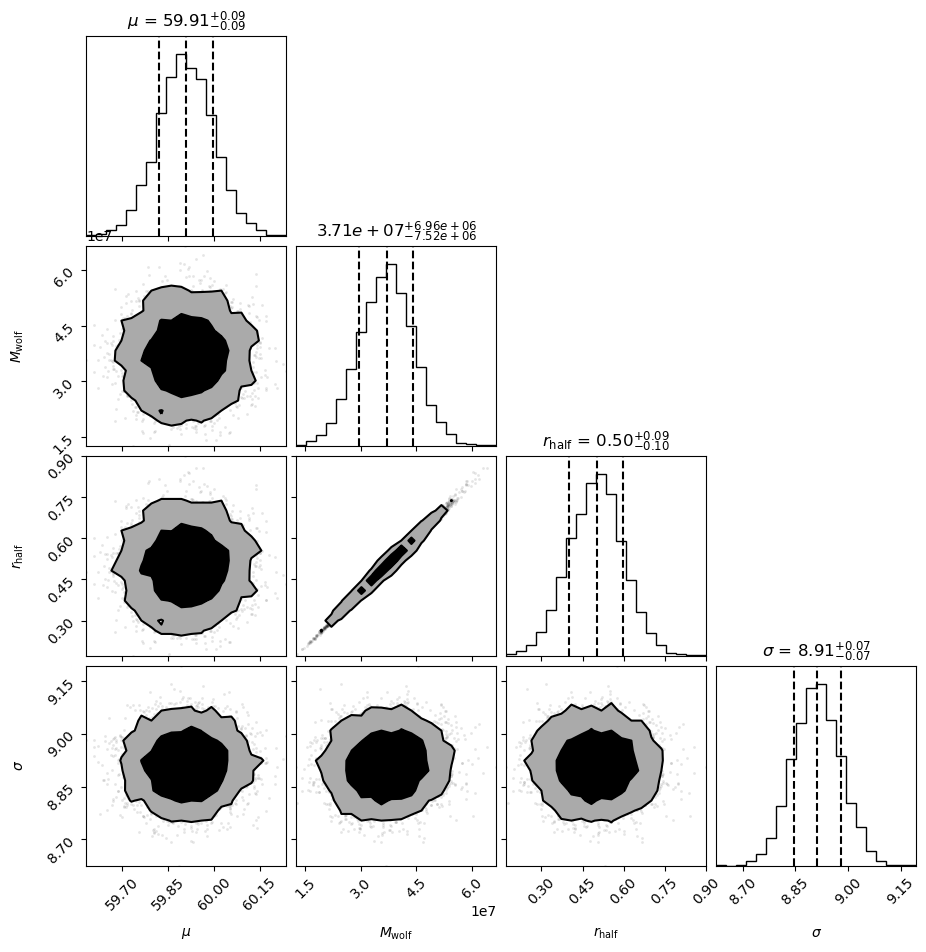

In [21]:
rhalf = {
    "dist": dist.Normal,
    "params": {
        "loc": 0.5,
        "scale": 0.1,
    },  # mean and std of the normal distribution in kpc
}
mcmc = Data.global_dispersion(
    vlos,
    dvlos,
    plot=True,
    priors=priors,
    half_light=rhalf,
)


### sanity check

Lets generate some fake data and see if we can recover the input values

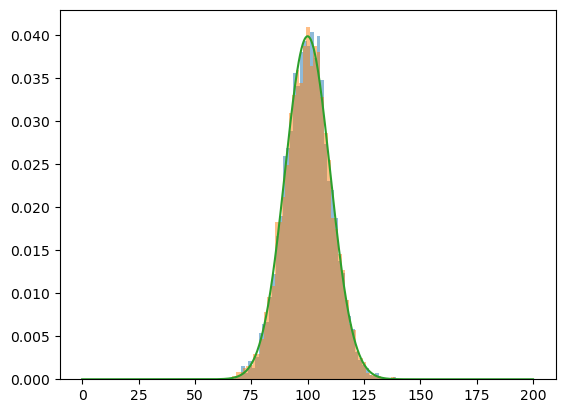

In [11]:
import numpy as np


def normal(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


N = 5_000

# set seed
np.random.seed(42)
v_true = np.random.normal(
    100,
    10,
    N,
)

## add error
error = np.random.normal(0, 2, N)
v = v_true + error

fig, ax = plt.subplots()
ax.hist(v_true, bins="auto", density=True, alpha=0.5)
ax.hist(v, bins="auto", density=True, alpha=0.5)
x = np.linspace(0, 200, 1000)
ax.plot(x, normal(x, 100, 10))


In [12]:
# we dont have to inialize the model, we can just use the function directly

In [13]:
from numpyro import distributions as dist

priors = {"mu": dist.Uniform(-50, 150), "sigma": dist.Uniform(0, 50)}
mcmc = Data.global_dispersion(v, 2, plot=False, priors=priors)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

          mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  ess_bulk  \
mu     100.035  0.143   99.884  100.169      0.002    0.001    5317.0   
sigma    9.967  0.104    9.870   10.079      0.002    0.001    3777.0   

       ess_tail  r_hat  
mu       3871.0    1.0  
sigma    3414.0    1.0  


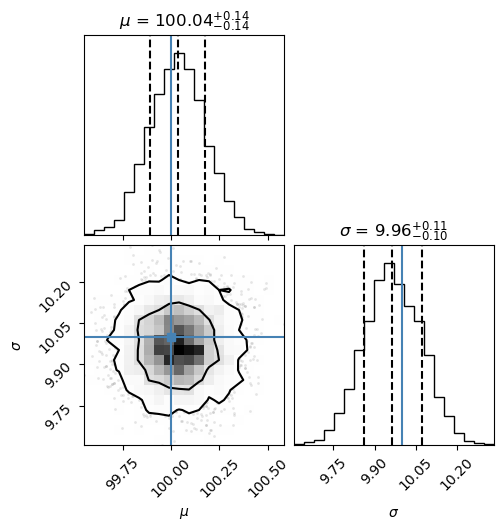

In [14]:
# mcmc.print_summary()
samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)
summary = az.summary(idata, hdi_prob=0.68)
print(summary)

_fig = corner.corner(
    samples,
    labels=[r"$\mu$", r"$\sigma$"],
    quantiles=[0.16, 0.5, 0.84],
    truths=[100, 10],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    plot_datapoints=True,
    levels=(0.68, 0.95),
)
plt.show()

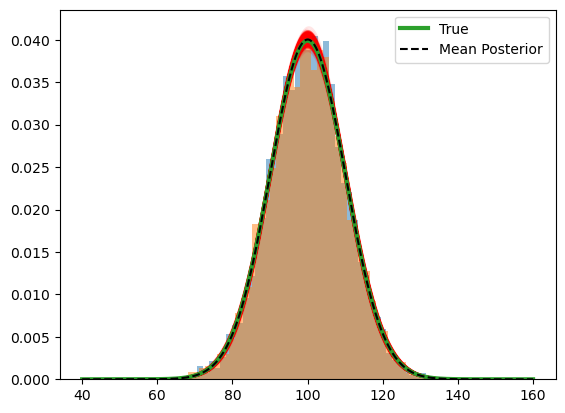

In [15]:
from scipy.stats import norm

fig, ax = plt.subplots()
ax.hist(v_true, bins="auto", density=True, alpha=0.5)
ax.hist(v, bins="auto", density=True, alpha=0.5)
x = np.linspace(40, 160, 1000)


posterior_mu = mcmc.get_samples()["mu"]
posterior_sigma = mcmc.get_samples()["sigma"]

# Plot multiple posterior distributions
num_samples = 1000  # Number of posterior samples to plot
for i in range(num_samples):
    mu = np.random.choice(posterior_mu)
    sigma = np.random.choice(posterior_sigma)
    ax.plot(x, norm.pdf(x, mu, sigma), color="red", alpha=0.1)
# Plot the mean posterior distribution
mean_mu = np.mean(posterior_mu)
mean_sigma = np.mean(posterior_sigma)
ax.plot(x, normal(x, 100, 10), label="True", lw=3)
ax.plot(
    x,
    norm.pdf(x, mean_mu, mean_sigma),
    color="black",
    label="Mean Posterior",
    linestyle="--",
)
ax.legend()